# Numerical ODEs

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
* https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations
* http://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node5.html
* https://en.wikipedia.org/wiki/Stiff_equation

See also a bunch of wikipedia pages on Runga-Kutta

## Imports etc...

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=1000)

mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 10,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
    "lines.linewidth" : 0.8,
    "lines.markersize" : 3,
})

# The basics

1) Let's say we have a differential equation `dy / dt = 2t`

2) Just from integrating both sides we know: `y(t) = t^2 + C`

3) And if we say that at t=2, y=2: `y(t) = t^2 - 2`

But what if we can't do step 2 analytically. Can we find `y(t)` numerically?

/home/christopher/.virtualenvs/learning/lib/python3.6/site-packages/scipy/integrate/_ivp/rk.py:145: RuntimeWarning: divide by zero encountered in double_scalars
  max(1, SAFETY * error_norm ** (-1 / (order + 1))))


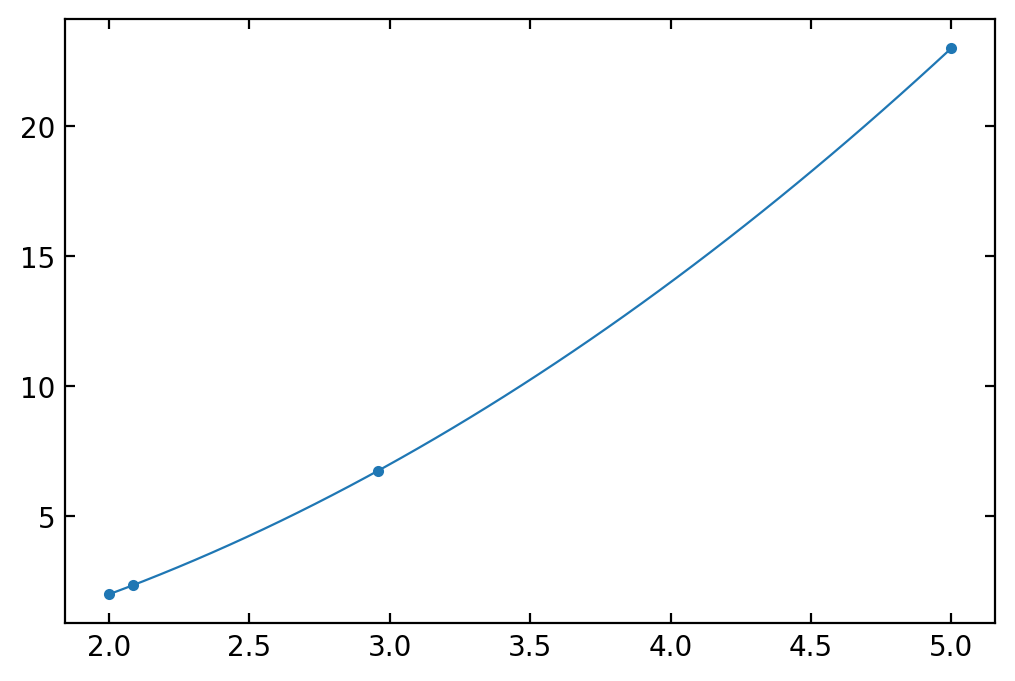

In [5]:
# The above system solved numerically

def dy_dt(t, y):
    return 2 * t

def analytical_y_t(t):
    return t**2 - 2

t = np.linspace(2, 5)
_, ax = plt.subplots()
ax.plot(t, analytical_y_t(t))

res = scipy.integrate.solve_ivp(dy_dt, t_span=(2, 5), y0=(2,))
assert res.success
ax.scatter(res.t, res.y[0])

Another example:

`dy / dt = -0.5 * y`, analytically `y(t) = C * e^(-0.5 * t)` and say at t=0, y(t) = 10 therefore `y(t) = 10 * e^(-0.5 * t)`

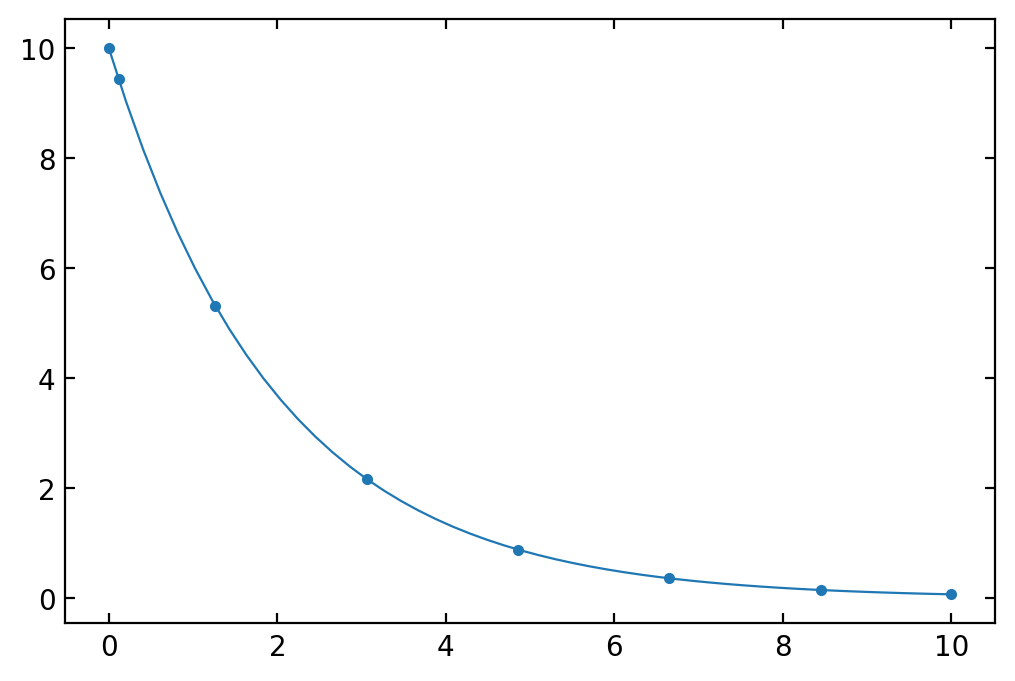

In [33]:
def dy_dt(t, y):
    return -0.5 * y

def analytical_y_t(t):
    return np.exp(-0.5 * t) * 10

t = np.linspace(0, 10)
_, ax = plt.subplots()
ax.plot(t, analytical_y_t(t))

res = scipy.integrate.solve_ivp(dy_dt, t_span=(0, 10), y0=(10,))
assert res.success
ax.scatter(res.t, res.y[0])

# Basic Theory

Ok, fantastic this works. But how does it  do it? It turns out there are many ways we could do it:

In [134]:
def dy_dt(t, y):
    return np.cos(t) + 1

def dy_dt2(t, y):
    return -np.sin(t)

def analytical_y_t(t):
    return np.sin(t) + t

In [135]:
t_init, t_end = 0, 20
t_true = np.linspace(t_init, t_end, num=1000)
true = analytical_y_t(t_true)

t = np.linspace(t_init, t_end, num=21)
dt = t[1] - t[0]

## Euler Method

20.912945250727628 20.83556753602631


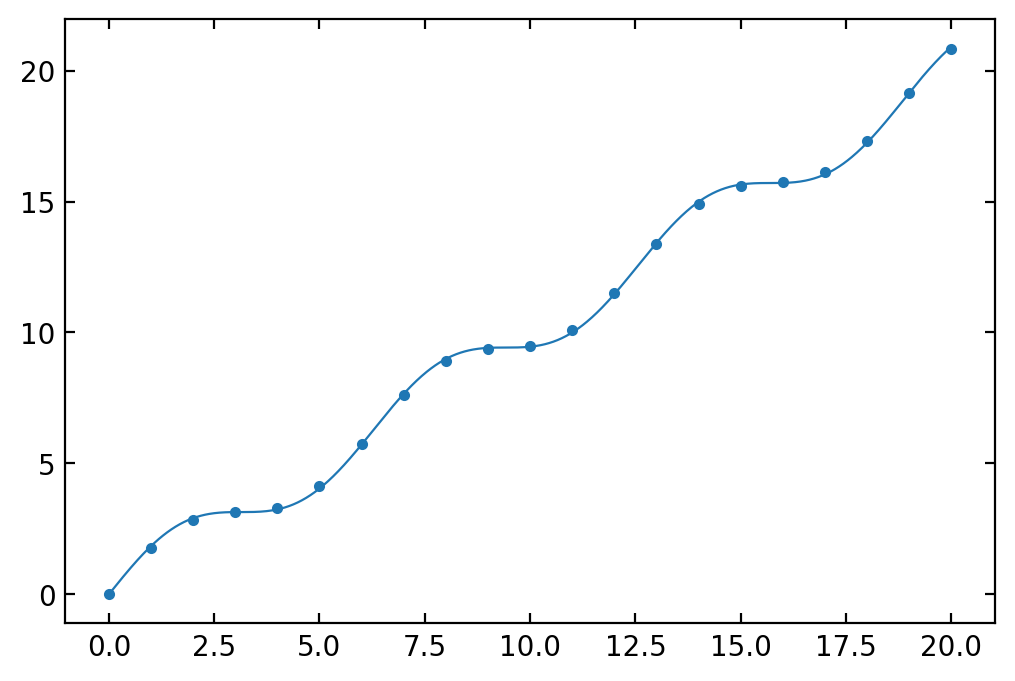

In [136]:
# Perhaps the simplest way. However this isn't that accurate.
# This is a first order method.

y = [0, ]
for i in range(1, len(t)):
    avg_slope = (
        dy_dt(t[i], y[-1]) + 
        dy_dt(t[i-1], y[-1])
    ) / 2
    y.append(
        y[-1] + avg_slope * dt
    
    )

_, ax = plt.subplots()
ax.plot(t_true, true)
ax.scatter(t, y)

print(true[-1], y[-1])

## Leapfrog method

0.9129452507276277 1.204162162319745


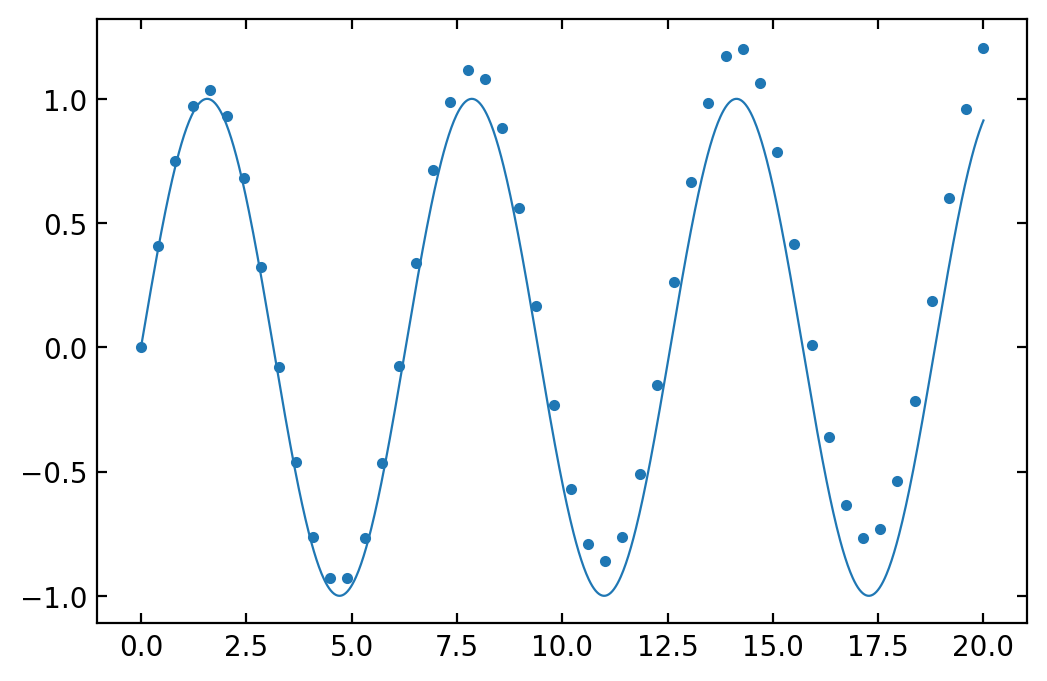

In [82]:
# A second order method. This is meant to be better than the previous one but it isn't...

y = [0, ]
v = dy_dt(t[0], y[0]) # This is v[0]
a = dy_dt2(t[0], y[0]) # This is a[0]


for i in range(1, len(t)):
    # set v[i - 1/2]
    v = v + a * dt / 2
    
    # set y[i]
    y.append(y[i-1] + v * dt)
    
    # set a[i]
    a = dy_dt2(t[i], y[i])
    
    # now set v[i]
    v = v + a * dt / 2
    
_, ax = plt.subplots()
ax.plot(t_true, true)
ax.scatter(t, y)

print(true[-1], y[-1])

## Runge-Kutta 4

20.912945250727628 20.913271934123117


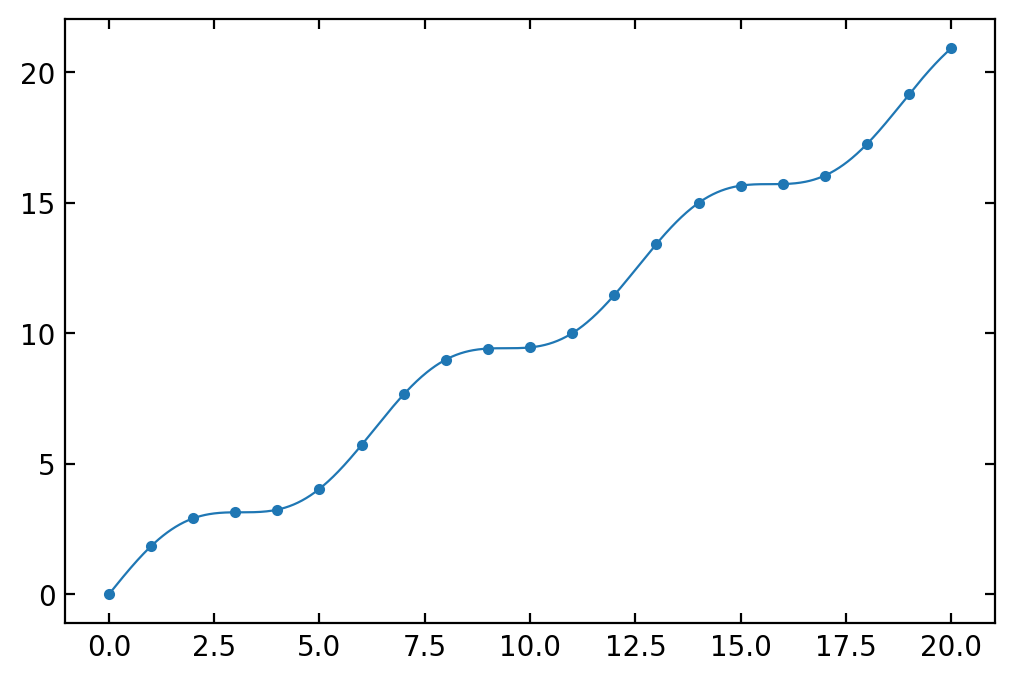

In [138]:
y = [0, ]

for i in range(1, len(t)):
    t_mid = t[i-1] + dt/2
    k1 = dt * dy_dt(t[i-1], y[i-1]) # The gradient at the start of the interval * dt
    k2 = dt * dy_dt(t_mid, y[i-1] + k1/2) # An approximation of the gradient at the middle * dt
    k3 = dt * dy_dt(t_mid, y[i-1] + k2/2) # Another approximation of the gradient at the middle * dt
    k4 = dt * dy_dt(t[i], y[i-1] + k3) # An approximation of the gradient at the end
    
    y.append(
        y[i-1] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    )
    
_, ax = plt.subplots()
ax.plot(t_true, true)
ax.scatter(t, y)

print(true[-1], y[-1])

# Euler Stability

In [75]:
a = 10
def dy_dt(t, y):
    return -a * y

def analytical_y_t(t):
    return np.exp(- a * t)

In [97]:
t_init, t_end = 0, 0.4
t_true = np.linspace(t_init, t_end, num=1000)
true = analytical_y_t(t_true)

0.0003650856136889931
0.0035347559472995865
0.006786423842665711
0.0014453195298845117
0.002849163056890704


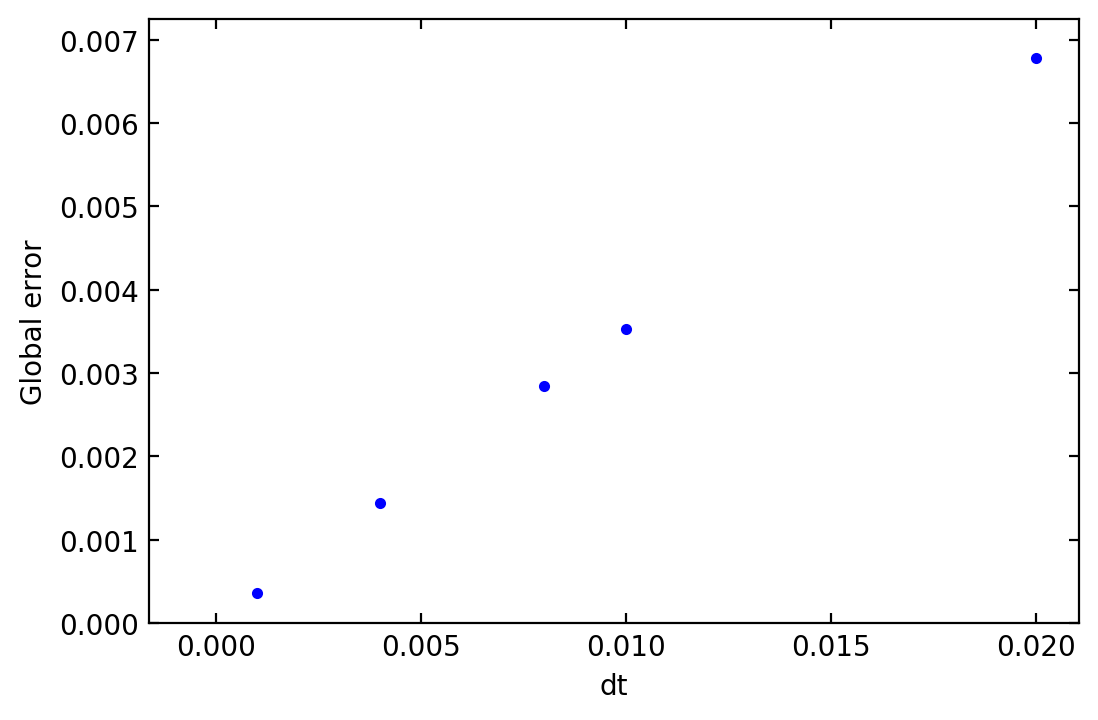

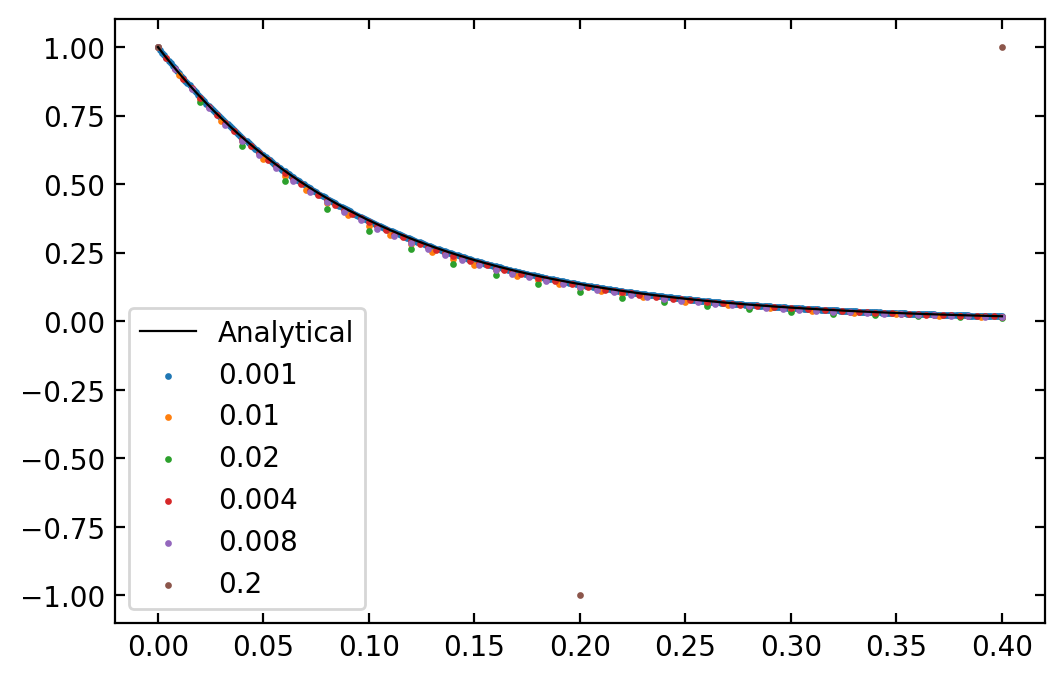

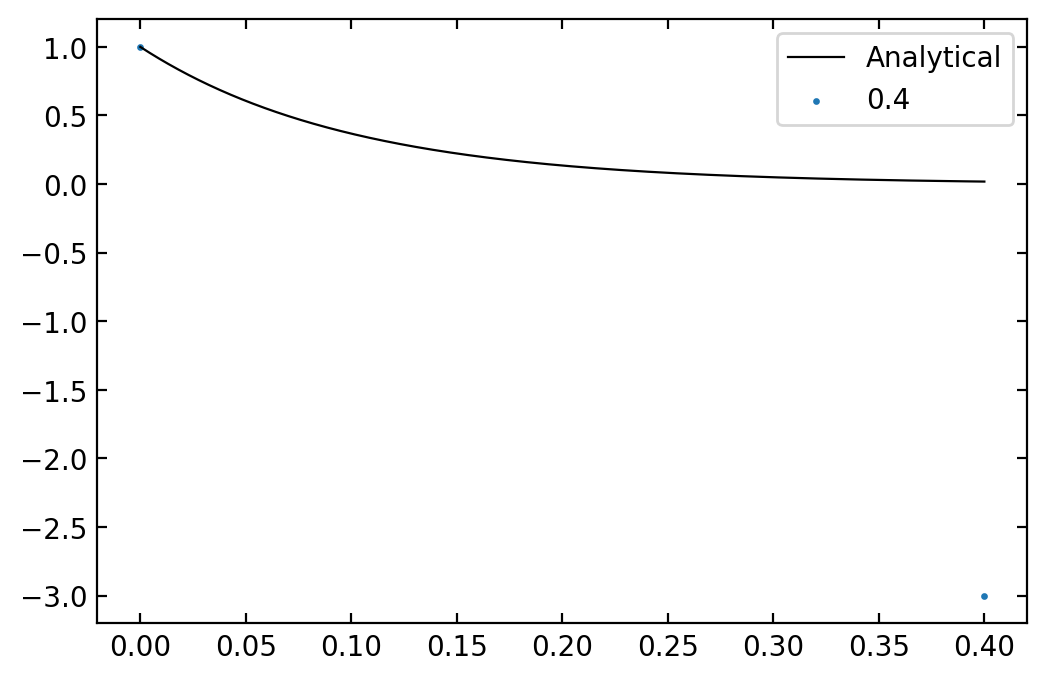

In [101]:
_, fax = plt.subplots()

for dts in [
    [0.001, 0.01, 0.02, 0.004, 0.008, 0.2],
    [0.2225],
]:
    _, ax = plt.subplots()
    ax.plot(t_true, true, label="Analytical", color="black")
    
    for dt in dts:
        num = int((t_end - t_init) / dt + 1)
        t = np.linspace(t_init, t_end, num=num)
        dt = t[1] - t[0]

        y = [1,]
        for i in range(1, len(t)):
            y.append(
                y[i-1] + dy_dt(t[i-1], y[i-1]) * dt
            )
        ax.scatter(t, y, label=str(dt), s=2)
        
        if dt < 0.2:
            print(np.abs(y[-1] - true[-1]))
            fax.scatter(dt, np.abs(y[-1] - true[-1]), color = "blue")
    ax.legend()
    fax.set(
        xlabel="dt", ylabel="Global error", ylim=(0, fax.get_ylim()[1]),
    )

# Stiffness

I'm not fully clear on this (but reading the wikipedia page it doesn't sound like anyone really is). It sounds like for some systems of differential equations (note, not the solutions, but for some formulations of the derivatives) the numerical solvers think that they need a really tiny step, despite there not being a huge amount of variation in the function. They therefore fail to solve it in any reasonable amount of time.